# major problem what we have is that the models try to generalise to all cells and do not focus on local temporal features

in this notebook we are going to simplify our problem by only looking at the individual cells. This allows us to ocmpare different techniques like the moving averages and actual hawkes processes (point processes)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

In [ ]:
%ls ./data/processed

# T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
# T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/

In [3]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult
from utils.mock_data import mock_rnn_data_classification, mock_rnn_data_regression
import matplotlib.pyplot as plt
from utils.plots import im

------

In [4]:
data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
data_dim_str = data_dim_str + "_2013-01-01_2015-01-01"
conf = BaseConf()

conf.model_name = "GRU"  # needs to be created
data_path = f"./data/processed/{data_dim_str}/"
conf.model_path = f"{data_path}models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-25T21:55:42 | root | INFO | =====================================BEGIN=====================================
2019-10-25T21:55:42 | root | INFO | Device: cpu


In [5]:
# GET DATA
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-10-25T21:55:42 | root | INFO | Data shapes of files in generated_data.npz
2019-10-25T21:55:42 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-25T21:55:43 | root | INFO | 	crime_types_grids shape (730, 10, 47, 33)
2019-10-25T21:55:43 | root | INFO | 	crime_grids shape (730, 1, 47, 33)
2019-10-25T21:55:43 | root | INFO | 	tract_count_grids shape (730, 1, 47, 33)
2019-10-25T21:55:43 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-25T21:55:43 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-25T21:55:43 | root | INFO | 	time_vectors shape (731, 52)
2019-10-25T21:55:43 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-25T21:55:43 | root | INFO | 	x_range shape (33,)
2019-10-25T21:55:43 | root | INFO | 	y_range shape (47,)
2019-10-25T21:55:43 | root | INFO | 	t_range shape (731,)


In [ ]:
    
    
model = RNN_crime(vocab_size, embed_size, hidden_size, num_layers)
# model.cuda()

# # Loss and Optimizer
# if is_weighted_loss:
#     criterion = nn.CrossEntropyLoss(weight=weights)
# else:
#     criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

# Truncated Backpropagation 
def detach(states):
    return [state.detach() for state in states] 

print("Model Training Starting...")

# Training and validation
for epoch in range(num_epochs): # TODO: Change to epoch length 
    for start in range(1): #TODO: change 1 to seq length # this is done to ensure more available training data

        for i in range(start, train.size(1) - seq_length, seq_length):
            #Train model
            model.train()
            
            # Get batch inputs and targets
            # inputs = Variable(train[:, i:i+seq_length]).cuda()
            # targets = Variable(train[:, (i+1):(i+1)+seq_length].contiguous()).cuda()
            inputs = Variable(train[:, i:i+seq_length])
            targets = Variable(train[:, (i+1):(i+1)+seq_length].contiguous())

            # Forward + Backward + Optimize
            model.zero_grad()

            # hidden states not reinitialised - same h_state is propogated forward
            # hidden states must be detached from history because the weights have been updated
            states = detach(states) 

            outputs, states = model(inputs, states) 
            loss = criterion(outputs, targets.view(-1))
            loss.backward() #no retain graph - work with set sequence lenght
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()

            print('{{"metric": "train loss", "value": {}}}'.format(loss.data[0]))

            step = (i // seq_length) + 1
            if step % 1 == 0:
                print ('Epoch [%d/%d], Step[%d/%d], Loss: %.3f, Perplexity: %5.2f' %
                       (epoch+1, num_epochs, step, num_batches, loss.data[0], np.exp(loss.data[0])))

            # Validate model
            # Calculate the evaluation metrics
            model.eval()

            val_outputs, _ = model(val_inputs, val_states)
            val_loss = criterion(val_outputs, val_targets.view(-1))

            # Save Ideal Model on Validation Set (Early Stopping)
            if (val_loss.data[0] < min_val_los):
                min_val_los = val_loss.data[0] 
                ideal_model_state = model.state_dict()


# Generating mock data for the models
### Cumsum example from tutorial [5 Examples of Simple Sequence Prediction Problems for LSTMs](https://machinelearningmastery.com/sequence-prediction-problems-learning-lstm-recurrent-neural-networks/)

In [131]:
class MockLoaders:
    def __init__(self, train_loader=None, validation_loader=None, test_loader=None):
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader
    

class MockRNNLoader:
    def __init__(self, seq_len, batch_size, n_samples):
        
        X,t = mock_rnn_data(seq_len=seq_len, batch_size=n_samples) #(seq_len, batch_size, n_features)                
        
        indices = np.expand_dims(np.arange(n_samples), axis=0)
        indices = np.expand_dims(indices, axis=2)
        
        vectors = [indices]
        i = 0
        for j in vector_size:
            vectors.append(X[:,:,i:i+j])
            i += j
        vectors.append(y)    
        
        self.n_samples = n_samples
        self.n_feats = n_feats
        self.vectors = vectors
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(self.n_samples / self.batch_size))
        self.current_batch = 0
        
        
        self.max_index = n_samples
        self.min_index = 0
        self.dataset = self # just to act as an interface
   
    def __len__(self):
        return self.n_samples

    def __iter__(self):
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        else:
            self.current_batch += 1
            start_index = (self.current_batch - 1) * self.batch_size
            stop_index = self.current_batch * self.batch_size
            if stop_index > len(self):
                stop_index = len(self)
            return self[start_index:stop_index]
        
            
    def __getitem__(self, index):        
        return tuple(map(lambda x: x[:,index], self.vectors))
    
vector_size= [3,6,13]#[37,65,512]
batch_size = 100    
class_split=0.5
train_loader = MockLoader(vector_size, batch_size, n_samples=7000, class_split=class_split)
validation_loader = MockLoader(vector_size, batch_size, n_samples=1000, class_split=class_split)
test_loader = MockLoader(vector_size, batch_size, n_samples=2000, class_split=class_split)
loaders = MockLoaders(train_loader,validation_loader,test_loader)

X,t = mock_rnn_data() #(seq_len, n_features, batch_size)
X,t  = np.swapaxes(X,1,2),np.swapaxes(t,1,2) # (seq_len, batch, input_size)

NameError: name 'MockLoader' is not defined

In [1]:
import numpy as np

In [316]:
class GRUMLPClassifier(nn.Module):
    """
    GRU then a MLP (flattens data output to easier use in NLLLoss)
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUMLPClassifier, self).__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)  # note batch first
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        if h0 is not None:
            out, hn = self.gru(x, h0)
        else:
            out, hn = self.gru(x)  # hidden state start is zero
        out = self.lin1(out)
        out = self.relu(out)
        out = self.lin2(out)

        # Reshape output to (batch_size*seq_len, hidden_size)
#         out = out.contiguous().view(out.size(0) * out.size(1), out.size(2))

        return out  # if we never send h its never detached

(10, 20, 1) (10, 20, 1)


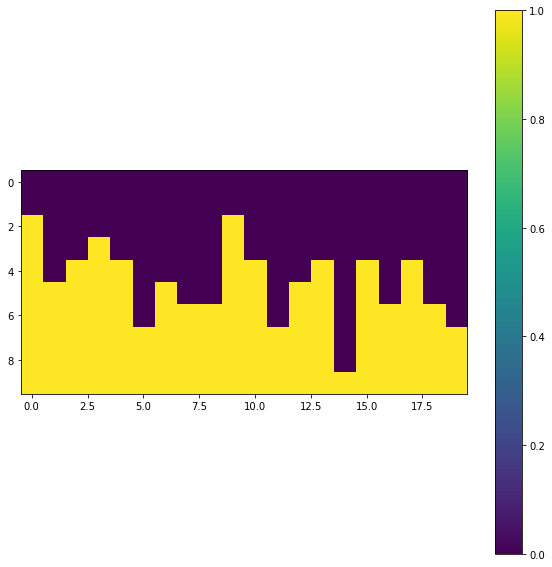

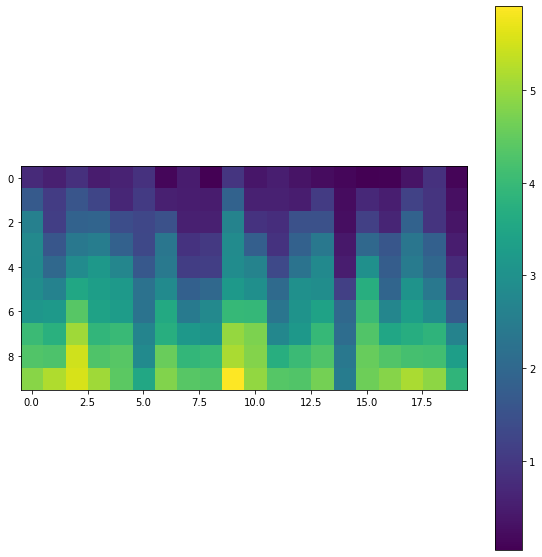

In [317]:
X, t = mock_rnn_data(seq_len=10, batch_size=20)
print(X.shape, t.shape)
y = np.cumsum(X, axis=0)
im(t[...,0])
im(y[...,0])

In [197]:
Variable(torch.ones(10)).requires_grad, torch.Tensor(10).requires_grad,y_pred.requires_grad

(False, False, True)

In [264]:
# CRIME DATA    
conf.seq_len = 10
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)
for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
    for i in [indices, spc_feats, tmp_feats, env_feats, targets]:
        print(np.shape(i))
    break    

2019-10-23T21:49:15 | root | INFO | Data shapes of files in generated_data.npz
2019-10-23T21:49:15 | root | INFO | 	crime_feature_indices shape (11,)
2019-10-23T21:49:15 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-10-23T21:49:15 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-10-23T21:49:15 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-23T21:49:15 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-23T21:49:15 | root | INFO | 	time_vectors shape (366, 52)
2019-10-23T21:49:15 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-23T21:49:15 | root | INFO | 	x_range shape (33,)
2019-10-23T21:49:15 | root | INFO | 	y_range shape (47,)
2019-10-23T21:49:15 | root | INFO | 	t_range shape (366,)
(64, 3)
(1, 64, 37)
(10, 64, 65)
(1, 64, 512)
(10, 64, 1)


In [428]:
from torch.nn.utils import clip_grad_norm_
losses = []

n_epochs = 80
seq_len=23
batch_size=100


CLASSIFICATION = False
if CLASSIFICATION:
    input_size, hidden_size, num_layers = 1, 2, 2
    loss_fn = nn.CrossEntropyLoss()  # todo add class weights
    X, y = mock_rnn_data(seq_len=seq_len, batch_size=batch_size)
else:    
    input_size, hidden_size, num_layers = 2, 1, 2
    loss_fn = nn.MSELoss()
    X, y = mock_adding_problem_data(seq_len=seq_len, batch_size=batch_size)
    
print("X.shape, y.shape", X.shape, y.shape)    

X.shape, y.shape (23, 100, 2) (23, 100, 1)


In [429]:
model = nn.GRU(input_size, hidden_size, num_layers)
optimiser = optim.Adam(model.parameters(), lr=1e-2)
state_dict = model.state_dict()
optimiser_dict = optimiser.state_dict()

In [464]:
# train_loop - use conf to get device?
def train_epoch_for_gru(model, optimiser, batch_loader, loss_fn, total_losses, conf):
    """
    Training the model for a single epoch
    """
    epoch_losses = []
    num_batches = batch_loader.num_batches
    for indices, data, targets in batch_loader:
        
        data = torch.Tensor(data).to(conf.device)
        y_true = torch.LongTensor(targets).to(conf.device)

        optimiser.zero_grad()
        y_pred, h = model.forward(data)

        if not conf.use_seq_loss: # seq_loss means we look at entire sequence when calculating the loss.
            y_pred, y_true = y_pred[-1], y_true[-1]
        y_pred, y_true = y_pred.view(-1,2), y_true.view(-1)


        loss = loss_fn(input=y_pred, target=y_true)
        
        current_batch = batch_loader.current_batch

        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_fn(input=out, target=targets)
        epoch_losses.append(loss.item())
        total_losses.append(epoch_losses[-1])

        if model.training:  # not used in validation loops
            optimiser.zero_grad()
            clip_grad_norm_(model.parameters(), 0.5)
            loss.backward()
            optimiser.step()
            log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {epoch_losses[-1]:.4f}")
    mean_epoch_loss = np.mean(epoch_losses)
    return mean_epoch_loss  

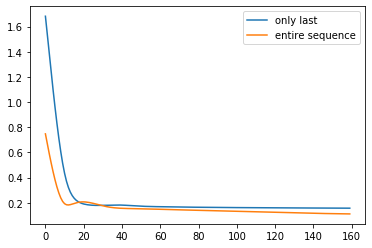

In [440]:
model = nn.GRU(input_size, hidden_size, num_layers)
optimiser = optim.Adam(model.parameters(), lr=1e-2)    
optimiser.load_state_dict(optimiser_dict)
model.load_state_dict(state_dict)
losses = []
losses_seq = []
for i in range(n_epochs*2):
    
    X = torch.Tensor(X).to(conf.device)
    
    optimiser.zero_grad()
    y_pred, h = model.forward(X)

    if CLASSIFICATION:
        y_true = torch.LongTensor(y).to(conf.device)
        y_pred, y_true = y_pred[-1], y_true[-1]
        y_pred, y_true = y_pred.view(-1,2), y_true.view(-1)
    else:
        y_true = torch.Tensor(y).to(conf.device)
        y_pred, y_true = y_pred[-1], y_true[-1]
        y_pred, y_true = y_pred.view(-1), y_true.view(-1)
     
    loss = loss_fn(input=y_pred, target=y_true)
    
    optimiser.zero_grad()
    loss.backward()
    clip_grad_norm_(model.parameters(), 0.5)
    optimiser.step()
    losses.append(loss.item())
    
    ######################################################################################
    y_pred, h = model.forward(X)
    if CLASSIFICATION:
        y_true = torch.LongTensor(y).to(conf.device)
        y_pred, y_true = y_pred.view(-1,2), y_true.view(-1)
    else:
        y_true = torch.Tensor(y).to(conf.device)
        y_pred, y_true = y_pred.view(-1), y_true.view(-1)
    loss_seq = loss_fn(input=y_pred, target=y_true)
    
    optimiser.zero_grad()
    loss_seq.backward()
    clip_grad_norm_(model.parameters(), 0.5)
    optimiser.step()
    
    losses_seq.append(loss_seq.item())
    
plt.plot(losses, label="only last") 
plt.plot(losses_seq, label="entire sequence")
plt.legend()
plt.show()

In [126]:
from utils.mock_data import mock_rnn_data
from data

In [127]:
X,t = mock_rnn_data(seq_len=30,batch_size=100) #(seq_len, n_features, batch_size)
X,t  = np.swapaxes(X,1,2),np.swapaxes(t,1,2) # (seq_len, batch, input_size)



In [9]:
log.info("test")


2019-10-19T20:23:20 | root | INFO | test


'RNN-CRIME-MODEL'

In [268]:
data_group.crimes.shape

(364, 1, 763)

In [10]:
loaders

In [ ]:
conf.early_stopping = True
conf.max_epochs = 20
conf.dropout = 0.
loss_function = nn.CrossEntropyLoss()

trn_loss = []  # epoch losses
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []  # batch losses
all_val_loss = []

# SET MODEL PARAMS
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]

# input_size = hidden_size = np.sum([spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]])
# model = SimpleFNN(input_size, hidden_size)

spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]
# model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model = SimpleKangFNN(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)

model.to(device)

# parameters = model.parameters()

parameters = [
                {'params': model.spcNet.parameters(), 'lr': 1e-3},    
                {'params': model.tmpNet.parameters(), 'lr': 1e-3},    
                {'params': model.envNet.parameters(), 'lr': 1e-3},
                {'params': model.finalNet.parameters(), 'lr': 1e-3}
            ]


# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

for epoch in range(conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    conf.timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.train_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
        current_batch = loaders.train_loader.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(device) # only taking [0] for fnn
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_function(input=out, target=targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")

    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {conf.timer.check()}")
    conf.timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU - todo put into a loop - then add wrapper
        for indices, spc_feats, tmp_feats, env_feats, targets in loaders.validation_loader:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(device)  # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(device)  # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(input=out, target=targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])

    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {conf.timer.check()}")
    
    log.info(f"\tlearning rate: \t{optimiser.param_groups[0]['lr']:.5f}")
    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    
    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

#     # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
#     if conf.early_stopping and epoch > 5 and np.sum(np.diff(val_loss[-5:])) > 0:  # increasing moving average
#         log.warning("Early stopping: Over-fitting has taken place")
#         break
        
#     if conf.early_stopping and epoch > 1 and np.abs(val_loss[-1]-val_loss[-2]) < conf.tolerance:
#         log.warning("Converged: Difference between the past two validation losses is within tolerance")
#         break

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)
    
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")    

## Examples of RNN training loops

In [ ]:
conf.early_stopping = True
conf.max_epochs = 20
conf.dropout = 0.
loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

# SET MODEL PARAMS
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]

# input_size = hidden_size = np.sum([spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]])
# model = SimpleFNN(input_size, hidden_size)

spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]
# model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model = SimpleKangFNN(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)

model.to(device)

# parameters = model.parameters()

parameters = [
                {'params': model.spcNet.parameters(), 'lr': 1e-3},    
                {'params': model.tmpNet.parameters(), 'lr': 1e-3},    
                {'params': model.envNet.parameters(), 'lr': 1e-3},
                {'params': model.finalNet.parameters(), 'lr': 1e-3}
            ]


# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

for epoch in range(conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    conf.timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.train_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
        current_batch = loaders.train_loader.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(device) # only taking [0] for fnn
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_function(input=out, target=targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")

    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {conf.timer.check()}")
    conf.timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for indices, spc_feats, tmp_feats, env_feats, targets in loaders.validation_loader:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(device)  # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(device)  # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(input=out, target=targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])

    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {conf.timer.check()}")

    
    log.info(f"\tlearning rate: \t{optimiser.param_groups[0]['lr']:.5f}")
    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    

    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

#     # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
#     if conf.early_stopping and epoch > 5 and np.sum(np.diff(val_loss[-5:])) > 0:  # increasing moving average
#         log.warning("Early stopping: Over-fitting has taken place")
#         break
        
#     if conf.early_stopping and epoch > 1 and np.abs(val_loss[-1]-val_loss[-2]) < conf.tolerance:
#         log.warning("Converged: Difference between the past two validation losses is within tolerance")
#         break
    
    if epoch > 3:
        model.dropout.p = ((conf.max_epochs - epoch)/conf.max_epochs)**2
    
    
    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)
    
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")    

In [ ]:
# Some part of the code was referenced from below.
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model
# which was in part referenced from below.
# https://github.com/pytorch/examples/tree/master/word_language_model 
# TODO: Add parsing capabilities
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable


import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from utils import *

# Hyper Parameters
embed_size = 100
hidden_size = 1000
num_layers = 1
num_epochs = 1
batch_size = 20
seq_length = 20 # month history
learning_rate = 0.002
is_weighted_loss = False

# Load Time Series
data = np.load("./data/time_series.npy")[:1000] # just select the centre square
data = threshold(data) # treshold data to 0 and 1 values

# Calculate the CrossEntropy weights for skew data (Rosenberg 2012)
values, counts = np.unique(data,return_counts=True)
weights = counts/np.sum(counts)
# weights = Variable(torch.FloatTensor([weights[1], weights[0]])).cuda()
weights = Variable(torch.FloatTensor([weights[1], weights[0]]))

vocab_size = int(data.max() + 1) # only two types - crime or no crime

n_trn_val_samps = int(len(data)*0.8)# 80:20 split data to train and test set
n_trn_samps = int(n_trn_val_samps*0.8)# 80:20 split train to train and validation set
train_and_validation = data[:n_trn_val_samps]
train = train_and_validation[:n_trn_samps]
validation = train_and_validation[n_trn_samps:]
test = data[n_trn_val_samps:]

# Setup train data
train = batchify(train,batch_size) # segment the data into batches
train = torch.LongTensor(train) #expects long tensor for the embedding

# Setup validation data and starting hidden state
validation = torch.LongTensor(validation)
validation = validation.view(1,-1) # reshape validation => 1 batch , many samples
# val_states = (Variable(torch.zeros(num_layers, 1, hidden_size)).cuda(), 
#                 Variable(torch.zeros(num_layers, 1, hidden_size)).cuda())
val_states = (Variable(torch.zeros(num_layers, 1, hidden_size)), 
                Variable(torch.zeros(num_layers, 1, hidden_size)))
# val_inputs = Variable(validation[:,:-1]).cuda()
# val_targets = Variable(validation[:,1:]).cuda()
val_inputs = Variable(validation[:,:-1])
val_targets = Variable(validation[:,1:])
min_val_los = 10000 #used to get early stopping parameters
ideal_model_state = {}

# Setup test data and starting hidden state
test = torch.LongTensor(test)
test = test.view(1,-1) # reshape test => 1 batch , many samples
# tst_states = (Variable(torch.zeros(num_layers, 1, hidden_size)).cuda(), 
#                 Variable(torch.zeros(num_layers, 1, hidden_size)).cuda()) #batch_size is one in testing case
tst_states = (Variable(torch.zeros(num_layers, 1, hidden_size)), 
                Variable(torch.zeros(num_layers, 1, hidden_size))) #batch_s
# tst_inputs = Variable(test[:,:-1]).cuda()
# tst_targets = Variable(test[:,1:]).cuda()
tst_inputs = Variable(test[:,:-1])
tst_targets = Variable(test[:,1:])

num_batches = train.shape[1] // seq_length

print("Hyper Parameters:\n================")
print("embed_size:\t",embed_size)
print("hidden_size:\t",hidden_size)
print("num_layers:\t",num_layers)
print("num_epochs:\t",num_epochs)
print("batch_size:\t",batch_size)
print("seq_length:\t",seq_length)
print("learning_rate:\t",learning_rate)
print("num_batches:\t",num_batches)
print("is_weighted_loss:\t",is_weighted_loss)

# RNN Based Crime Model
class RNN_crime(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNN_crime, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) # note batch first
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
        
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, h): # give seq_jump to know which hidden state to use for next sequence
        # Embed word crimes to vectors
        x = self.embed(x) 

        # Forward propagate RNN  
        out, h = self.lstm(x, h) # Not saving hidden state because seq_jump # init lstm weight to 1 to make easier

        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.contiguous().view(out.size(0)*out.size(1), out.size(2))

        # Decode hidden states of all time step
        out = self.linear(out)  
        return out, h # if we never send h its never detached
    
    
model = RNN_crime(vocab_size, embed_size, hidden_size, num_layers)
# model.cuda()

# Loss and Optimizer
if is_weighted_loss:
    criterion = nn.CrossEntropyLoss(weight=weights)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

# Truncated Backpropagation 
def detach(states):
    return [state.detach() for state in states] 

print("Model Training Starting...")

# Training and validation
for epoch in range(num_epochs): # TODO: Change to epoch length 
    for start in range(1): #TODO: change 1 to seq length # this is done to ensure more available training data
    
        # Initial hidden and memory states
        states = (Variable(torch.zeros(num_layers, batch_size, hidden_size)),
                  Variable(torch.zeros(num_layers, batch_size, hidden_size)))
    
        for i in range(start, train.size(1) - seq_length, seq_length):
            #Train model
            model.train()
            
            # Get batch inputs and targets
            # inputs = Variable(train[:, i:i+seq_length]).cuda()
            # targets = Variable(train[:, (i+1):(i+1)+seq_length].contiguous()).cuda()
            inputs = Variable(train[:, i:i+seq_length])
            targets = Variable(train[:, (i+1):(i+1)+seq_length].contiguous())

            # Forward + Backward + Optimize
            model.zero_grad()

            # hidden states not reinitialised - same h_state is propogated forward
            # hidden states must be detached from history because the weights have been updated
            states = detach(states) 

            outputs, states = model(inputs, states) 
            loss = criterion(outputs, targets.view(-1))
            loss.backward() #no retain graph - work with set sequence lenght
            torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()

            print('{{"metric": "train loss", "value": {}}}'.format(loss.data[0]))

            step = (i // seq_length) + 1
            if step % 1 == 0:
                print ('Epoch [%d/%d], Step[%d/%d], Loss: %.3f, Perplexity: %5.2f' %
                       (epoch+1, num_epochs, step, num_batches, loss.data[0], np.exp(loss.data[0])))

            # Validate model
            # Calculate the evaluation metrics
            model.eval()

            val_outputs, _ = model(val_inputs, val_states)
            val_loss = criterion(val_outputs, val_targets.view(-1))

            # Save Ideal Model on Validation Set (Early Stopping)
            if (val_loss.data[0] < min_val_los):
                min_val_los = val_loss.data[0] 
                ideal_model_state = model.state_dict()


In [ ]:
trn_collection = []
val_collection = []
best_model_val_collection = []
best_model_trn_collection = []

itrs = [5]

for itr in itrs:
    torch.manual_seed(itr)  # manual seed to test other params of the model and keep init weights constant

    print('Start Time:', pd.datetime.now(), '\n')

    # data loader setup
    n_epochs = 10
    seq_len = 24 * 3
    batch_size = 32
    lr = 1e-3

    S = Variable(torch.FloatTensor(subX)).view(-1, subX.shape[-1] ** 2)
    #   S = Variable(torch.FloatTensor(grids)).view(-1,grid_size**2)
    #   S = Variable(torch.FloatTensor(f[-500:]))
    S[S > cap] = cap
    S = S.cuda()
    #   S = S.mm(trans_mat_d2s)

    loader = DataLoader(S, batch_size, seq_len, shuffle=True)
    trnT, trnX, trnTimes = loader.getTrainBatch()
    loader.reset_current_t()
    trnT = trnT[:, :, 12:12 + 1]
    #   trnX = trnX.view(batch_size,seq_len,-1)

    # model setup
    input_size = trnX.shape[-1]
    output_size = trnT.shape[-1]
    hidden_size = 10 * trnX.shape[-1]
    num_layers = 1

    #   model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    model = GRU_MLPRegressor(input_size, hidden_size, output_size, num_layers=num_layers)
    model.cuda()
    print('\nMODEL\n', model)

    params = list(model.parameters())  # + list(h0) + list(c0)
    optimizer = optim.Adam(params=params, lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    n_steps = (loader.getTrainDataLength() // batch_size) + 1
    print("\nSteps per epoch", n_steps)

    train_losses = []
    validation_losses = []
    min_val_loss = np.inf  # used for early stopping TODO: IMPLEMENT MOVING AVERAGE AND STOP IF VAL LOSS IS MOVING UP, IE OVERFITTING

    valT, valX, valTimes = loader.getValidationSet()
    valT = valT[:, :, 12:12 + 1]

    for epoch in range(n_epochs):  # epoch is one iteration over the entire input data
        loader.reset_current_t()
        print("\nEpoch:", epoch)
        for step in range(n_steps - 1):
            # Train Evaluation and Optimization Step
            model.train()
            optimizer.zero_grad()
            trnT, trnX, trnTimes = loader.getTrainBatch()
            trnT = trnT[:, :, 12:12 + 1]  # choosing only center square
            #       trnY, (hn, cn) = model.forward(trnX, (h0, c0))
            trnY = model.forward(trnX)

            trnLoss = torch.sqrt(criterion(trnY[-1], trnT[-1]))  # SQRT MSE not same as MAE
            trnLoss.backward()
            #       if itr == 0:
            #         torch.nn.utils.clip_grad_norm(model.parameters(), 0.5) # Figure out fitting clip value
            optimizer.step()
            train_losses.append(trnLoss.cpu().item())

            # Validation Evaluation
            model.eval()
            valY = model.forward(valX)

            valLoss = torch.sqrt(criterion(valY[-1], valT[-1]))
            validation_losses.append(valLoss.cpu().item())

            if validation_losses[-1] < min_val_loss:
                min_val_loss = validation_losses[-1]
                best_model_val = model.state_dict()

            if len(validation_losses) % 50 == 0:
                print("Iteration:", len(validation_losses))

        print("Last Train Loss of Epoch:", train_losses[-1])
        print("Last Validation Loss of Epoch:", validation_losses[-1])
        print("Current Best Validation Loss:", min_val_loss)
    best_model_trn = model.state_dict()
    trn_collection.append(train_losses)
    val_collection.append(validation_losses)
    best_model_trn_collection.append(best_model_trn)
    best_model_val_collection.append(best_model_val)
    print('Stop Time:', pd.datetime.now(), '\n')

plt.figure()
plt.title("RMSE Loss of Model over Itterations")
for i, _ in enumerate(trn_collection):
    plt.plot(trn_collection[i], label='Training: ' + str(itrs[i]))
    plt.plot(val_collection[i], label='Validation: ' + str(itrs[i]))
    plt.scatter(np.argmin(val_collection[i]), np.min(val_collection[i]), marker='X', c='r')
plt.xlabel("Itteraion")
plt.ylabel("RMSE Loss")
plt.legend()
plt.show()